In [1]:
%run ../../utils/commonImports.py
%run ../../utils/tradingImports.py
%matplotlib inline

from base import supres, BaseStrategy

# Load Data

In [2]:
# dropbox_dir = 'D:\\Dropbox\\My work\\krypl-project'
dropbox_dir = '/Users/david.vesely/Dropbox/My work/krypl-project'

def read_data(pair):
    db = os.path.join(dropbox_dir,'sqlite', 'ploniex-chart-data', f'{pair}.db')
    data = load_trading_data(db, 'chart_data', from_date='2015-01-01', period='30min')
    data['ohlc4'] = (data['open'] + data['close'] + data['high'] + data['low']) / 4
    return data

In [3]:
supports_for_data_dict_test = load_model('supports-for-data-test.pkl')
supports_for_data_dict_train = load_model('supports-for-data.pkl')
supports_for_data_dict = {**supports_for_data_dict_train, **supports_for_data_dict_test}

In [4]:
features = ['support']

In [5]:
train_pairs = pd.read_csv('pairs_train.tsv', header=None)[0].tolist()
test_pairs = pd.read_csv('pairs_test.tsv', header=None)[0].tolist()
all_pairs = pd.read_csv('pairs.tsv', header=None)[0].tolist()
data_dict = {pair: read_data(pair) for pair in all_pairs}

# Parallelize

In [6]:
from multiprocessing import Pool
import time
from tqdm import *

def run_parallel(f, args, n_process=10):
    results = []
    with Pool(processes=n_process) as p:
        all_args = list(args)
        with tqdm_notebook(enumerate(p.imap_unordered(f, all_args)), leave=False, total=len(all_args)) as pbar:
            for i, x in pbar:
                results.append(x)
                pbar.update()
                
        return results

In [7]:
def dict_from_list(l):
    d = {}
    for row in l:
        d_inner = d
        for k in row[:-2]:
            if k not in d_inner.keys():
                d_inner[k] = {}
            d_inner = d_inner[k]
        d_inner[row[-2]] = row[-1]
    return d

# Multicoin strategy

In [8]:
def combine_dicts(d1, d2):
    keys = list(d1.keys()) + list(d2.keys())
    d = {}
    for k in keys:
        v1, v2 = d1.get(k, None), d2.get(k, None)
        if v1 is None:
            d[k] = v2
        elif v2 is None:
            d[k] = v1
        elif type(v1) == dict:
            d[k] = combine_dicts(v1, v2)
        else:
            d[k] = v1 + v2
    return d

In [59]:
class MulticoinStrategy():
    def __init__(self, data_dict, pairs, willing_loss, target_profit, target_return):
        self.data_dict = data_dict
        self.pairs = pairs
        self.willing_loss = willing_loss
        self.target_profit = target_profit
        self.target_return = target_return
        self.strategies = {}
        self.wallet = {'btc': 100}
    
    
    def trade_pair(self, pair):
        contract_pair = ContractPair.new(*[x.lower() for x in pair.split('_')])
        data = self.data_dict[pair]
        dm = OhlcDataManager(data[['open', 'low', 'high', 'close']], data[features])
        wallet = deepcopy(self.wallet)
        wallet[contract_pair['priceContract']] = wallet[contract_pair['priceContract']] / len(self.pairs)
        exchange = BackTestExchange(dm, wallet, 0.0025)
        strategy = BaseStrategy(exchange, 
                                dm, 
                                contract_pair, 
                                willing_loss=self.willing_loss, 
                                target_profit=self.target_profit, 
                                target_return=self.target_return)
        strategy.trade()
        return pair, strategy
    
    def trade(self):
        results = run_parallel(self.trade_pair, self.pairs)
        self.strategies = dict_from_list(results)
    
    def all_transactions_with_timestamp(self):
        transactions = deepcopy(self.all_transactions())
        for t in transactions:
            price_c = t['pair']['priceContract'].upper()
            trade_c = t['pair']['tradeContract'].upper()
            data = data_dict[f'{price_c}_{trade_c}']
            ts = t['timestamp']
            t['timestamp'] = data['timestamp'].iloc[ts] if ts < data.shape[0] else data['timestamp'].iloc[ts-1]
        return transactions
    
    def all_transactions(self):
        transactions = []
        for strategy in self.strategies.values():
            transactions += strategy.exchange.transactions
        return transactions
    
    def transactions(self, contract_name=None):
        if contract_name is None:
            return self.all_transactions()
        
        return self.strategies[contract_name].exchange.transactions
    
    def stats(self, contract_name):
        return Statistics(contract_name, self.wallet[contract_name])\
            .evaluate(self.all_transactions())

# Setup

In [60]:
window_size = 12
target_profit = 0.01
willing_loss = 0.06
target_return = -0.02

for pair in all_pairs:
    data = data_dict[pair]
    data['support'] = supports_for_data_dict[pair][window_size]

# Wallet history

In [195]:
import pandas as pd
import numpy as np
from trading.money.transaction import Transaction
    

class WalletHistory:
    def __init__(self, start_wallet):
        self.start_wallet = deepcopy(start_wallet)
        self.wallet = start_wallet
        self.wallet_history = {}

    def history(self, transactions):
        for transaction in transactions:
            if transaction['type'] == 'BUY':
                self._buy(transaction)
            else:
                self._sell(transaction)
        return self.wallet_history
                
    def _buy(self, transaction):
        subtracted = Contract.add(Transaction.subtracted_contract(transaction), transaction['fee'])
        gained = Transaction.gained_contract(transaction)
        self._add(gained)
        self._subtract(subtracted)
        

    def _sell(self, transaction):
        subtracted = Transaction.subtracted_contract(transaction)
        gained = Contract.sub(Transaction.gained_contract(transaction), transaction['fee'])
        self._add(gained)
        self._subtract(subtracted)
        self._add_to_history(self.wallet, transaction['timestamp'])
    
    def _add_to_history(self, wallet, ts):
        wallet_p = self.wallet_history.get(ts, {})
        self.wallet_history[ts] = combine_dicts(deepcopy(wallet), deepcopy(wallet_p))
    
    def _add(self, contract):
        name, value = contract
        self.wallet[name] = self.wallet.get(name, 0.) + value

    def _subtract(self, contract):
        self._add(Contract.mul(contract, -1))

In [1]:
def profolio_value_f(args):
    ts, wallet = args
    btc = wallet.get('btc', 0)
    for currency, amount in wallet.items():
        if currency == 'btc' or amount == 0:
            continue
        data = data_dict[f'BTC_{currency.upper()}']
        price = data[data['timestamp'] == ts]['close'].iloc[0]
        btc += amount * price

    return ts, btc


def portfolio_value(multi_strategy, pair=None):
    def get_price(ts):
        data = data_dict[pair]
        row = data[data['timestamp'] == ts].iloc[0, :]
        return row['close']
        
    transactions = multi_strategy.all_transactions_with_timestamp()
    history = WalletHistory({'btc': 100}).history(transactions)
    args = history.items()
    results = run_parallel(profolio_value_f, args)
    df = pd.DataFrame(results, columns=['timestamp', 'btc'])
    df['btc_return_%'] = ((df['btc'] / 100) - 1) * 100
    if pair is not None:
        df['hold'] = df['timestamp'].apply(get_price)
        first_price = get_price(data_dict[pair]['timestamp'].min())
        df['hold_return_%'] = ((df['hold'] / first_price) - 1) * 100
    return df

In [172]:
import matplotlib.dates as md
def plot_portfolio_value(df, step=10, title='Portfolio return over time'):
    
    f = plt.figure(figsize=[12, 6])

    df['date'] = df['timestamp'].apply(dt.datetime.fromtimestamp)
    selected = df.iloc[[i for j, i in enumerate(df.index) if j % step == 0], :]\
        .sort_values('timestamp')\
        .reset_index()
    xdates = selected['date']
    ax = sns.lineplot(xdates, selected['btc_return_%'], label='btc')
    if 'hold' in df.columns:
        ax = sns.lineplot(xdates, selected['hold_return_%'], label='hold')
    
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(MaxNLocator(6))

    plt.title(title, fontproperties=title_font)
    plt.xlabel('date', fontproperties=axis_font)
    plt.ylabel('return (%)', fontproperties=axis_font)
    plt.show()

# Pairs Volume

In [157]:
volume_stats = pd.DataFrame()
for pair in all_pairs:
    data = data_dict[pair]
    pair_stats = data[['volume']].describe().transpose()
    pair_stats['sum'] = data['volume'].sum()
    pair_stats['pair'] = pair
    volume_stats = volume_stats.append(pair_stats)

cols = list(volume_stats.columns)
cols = cols[-1:] + cols[:-1]
volume_stats = reset_index_hard(volume_stats).sort_values('mean', ascending=False)[cols]

# Return per coin

In [151]:
multi_strategy = MulticoinStrategy(data_dict, ['BTC_HUC'], willing_loss, target_profit, target_return)
multi_strategy.trade()
multi_strategy.stats('btc').report()

,btc
startAmount,100.0000
numberOfTrades,386.0000
totalProfit,239.7561
avgProfit,0.6211
winPercentage,93.5233
avgWinTrade,2.2185
avgLossTrade,-22.4443
profitFactor,1.4273
maxDrawdown,32.5362
avgTimeToClose,6.4482


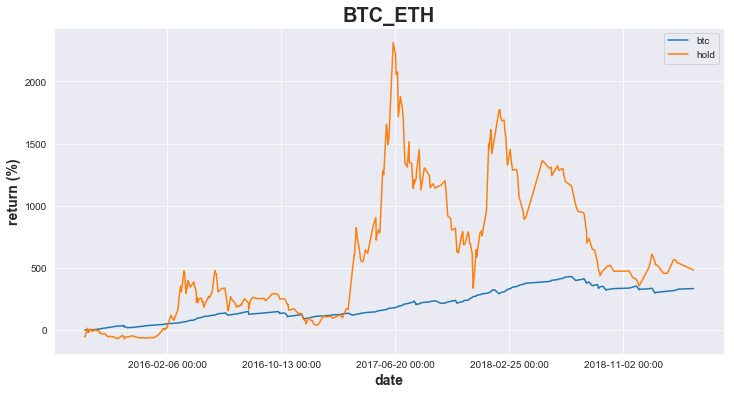

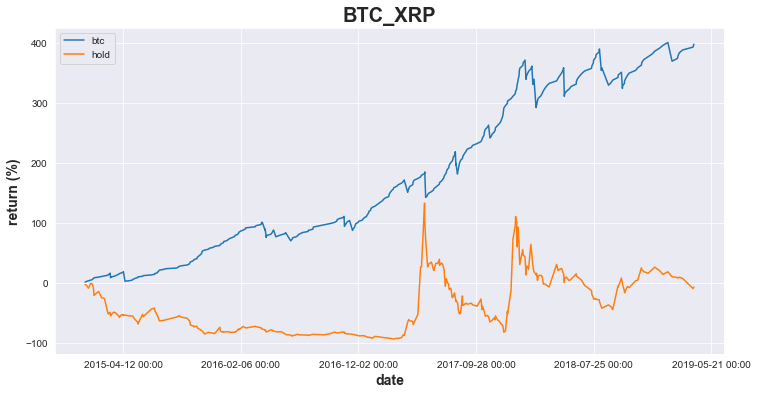

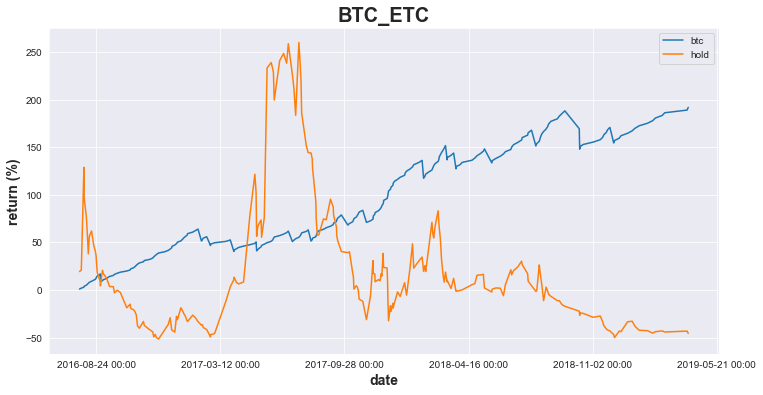

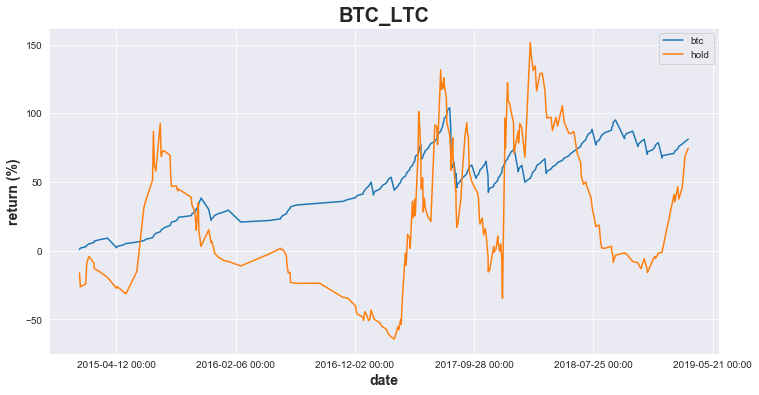

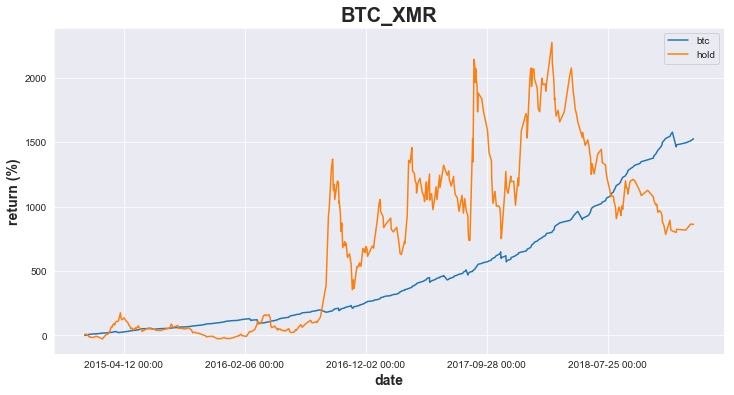

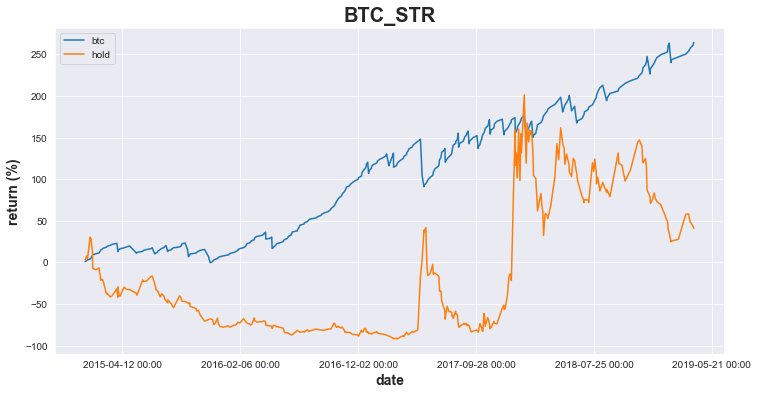

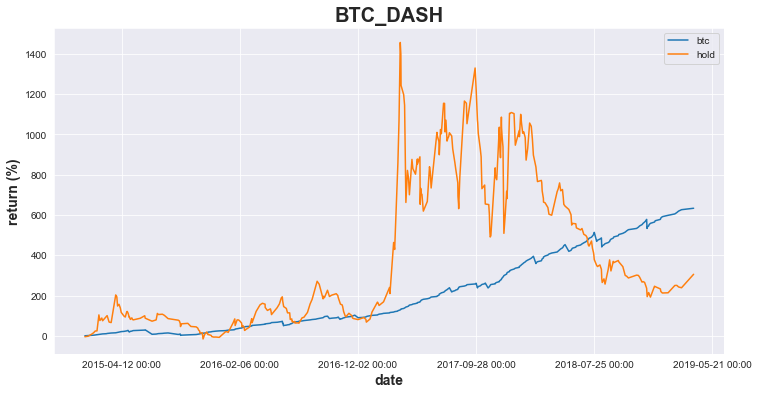

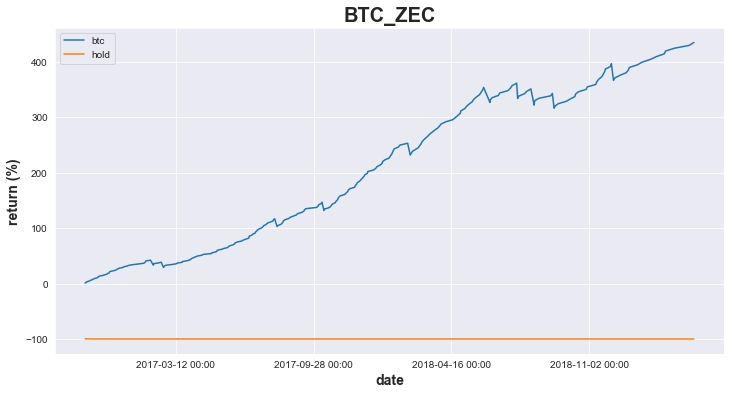

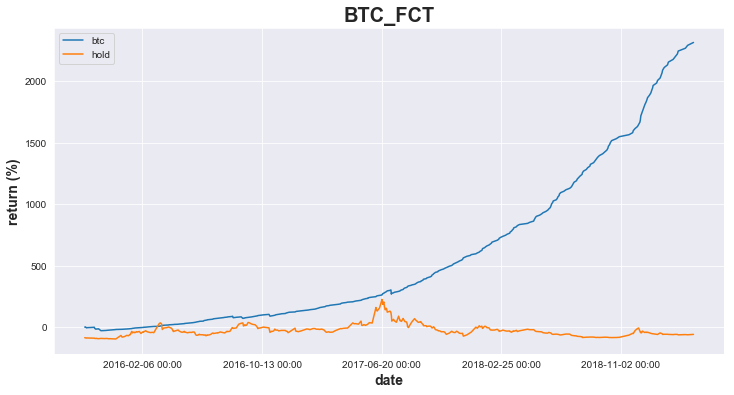

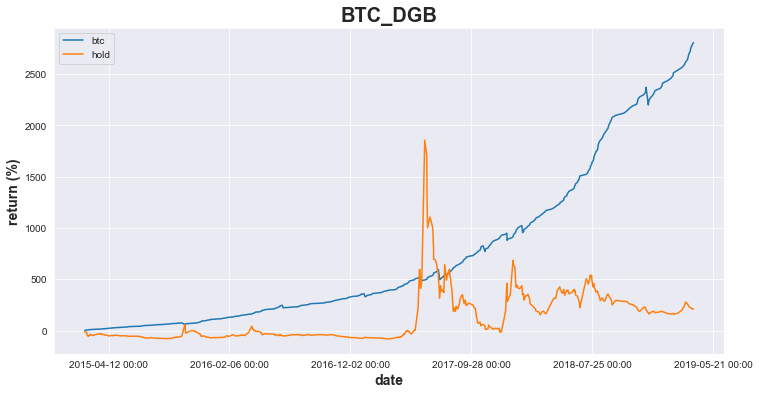

In [191]:
for pair in volume_stats['pair'].iloc[:10]:    
    multi_strategy = MulticoinStrategy(data_dict, [pair], willing_loss, target_profit, target_return)
    multi_strategy.trade()
    multi_strategy.stats('btc').report()
    
    df = portfolio_value(multi_strategy, pair)
    plot_portfolio_value(df, 1, pair)

# Test Results

In [132]:
multi_strategy_test = MulticoinStrategy(data_dict, test_pairs, willing_loss, target_profit, target_return)
multi_strategy_test.trade()
multi_strategy_test.stats('btc').report()

,btc
startAmount,100.0000
numberOfTrades,"7,303.0000"
totalProfit,554.1265
avgProfit,0.0759
winPercentage,95.4676
avgWinTrade,0.1177
avgLossTrade,-0.8052
profitFactor,3.0791
maxDrawdown,4.7714
avgTimeToClose,7.1464


# Portfolio over time with top coins

In [ ]:
multi_strategy = MulticoinStrategy(data_dict, volume_stats['pair'].iloc[:10], willing_loss, target_profit, target_return)
multi_strategy.trade()
multi_strategy.stats('btc').report()

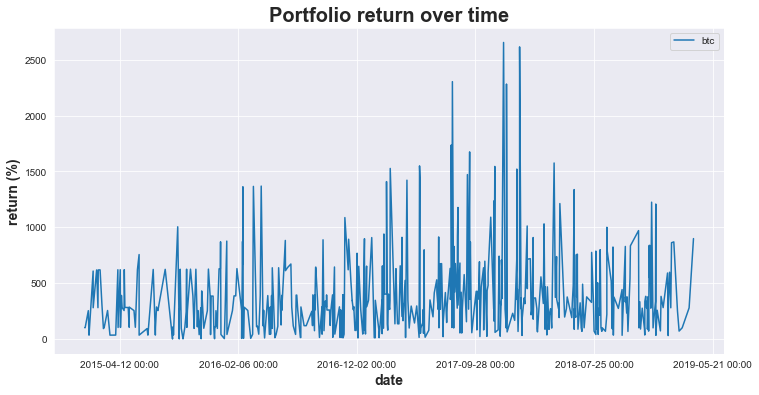

In [196]:
df = portfolio_value(multi_strategy)
plot_portfolio_value(df, 10)